In [62]:
import timm
import math
import torch
import torch.nn as nn
import torchvision
from typing import Optional

In [63]:
'''
https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz
vit_base_patch16_224
'''

net = timm.create_model("vit_base_patch16_224", pretrained=True)
torch.save(net,"checkpoint/vit_base_patch16_224.pth")
#net.head = torch.nn.Linear(net.head.in_features, 10)

In [64]:
open("checkpoint/vit_base_patch16_224.pth")

<_io.TextIOWrapper name='checkpoint/vit_base_patch16_224.pth' mode='r' encoding='cp936'>

In [65]:
model = torch.load("checkpoint/vit_base_patch16_224.pth")
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

In [66]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

In [67]:
transform1 = torchvision.transforms.Compose([
                                                torchvision.transforms.RandomCrop(32, padding=4),
                                                torchvision.transforms.Resize(32),
                                                torchvision.transforms.RandomHorizontalFlip(),
                                                torchvision.transforms.ToTensor(),
                                                #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                                torchvision.transforms.ConvertImageDtype(DTYPE)
                                             ])

transform2 = torchvision.transforms.Compose([
                                                torchvision.transforms.Resize(32),
                                                torchvision.transforms.ToTensor(),
                                                #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                                torchvision.transforms.ConvertImageDtype(DTYPE)
                                             ])

In [68]:
BATCH_SIZE = 75

epochs = 20

#lr = 0.002
lr = 0.01
momentum = 0.9

In [69]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=8, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=8, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
from torchvision.models.vision_transformer import Encoder
from functools import partial

class VisionTransformer(nn.Module):
    """Vision Transformer as per https://arxiv.org/abs/2010.11929."""

    def __init__(
        self,
        image_size: int,
        patch_size: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1000,
        representation_size: Optional[int] = None
    ):
        super().__init__()
        if image_size % patch_size != 0:
            print("Input shape indivisible by patch size!")
        self.image_size = image_size
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.representation_size = representation_size


        self.conv_proj = nn.Conv2d(
            in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size
        )

        seq_length = (image_size // patch_size) ** 2

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        seq_length += 1

        self.encoder = Encoder(
            seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
        )
        self.seq_length = seq_length

        self.heads = nn.Sequential(nn.Linear(hidden_dim, num_classes))

        if isinstance(self.conv_proj, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)
        elif self.conv_proj.conv_last is not None and isinstance(self.conv_proj.conv_last, nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.conv_proj.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / self.conv_proj.conv_last.out_channels)
            )
            if self.conv_proj.conv_last.bias is not None:
                nn.init.zeros_(self.conv_proj.conv_last.bias)

        if hasattr(self.heads, "pre_logits") and isinstance(self.heads.pre_logits, nn.Linear):
            fan_in = self.heads.pre_logits.in_features
            nn.init.trunc_normal_(self.heads.pre_logits.weight, std=math.sqrt(1 / fan_in))
            nn.init.zeros_(self.heads.pre_logits.bias)


    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x = self.heads(x)

        return x

In [71]:
'''

    model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        **kwargs,
    )

    return _vision_transformer(
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        weights=weights,
        progress=progress,
        **kwargs,
    )

'''
model = VisionTransformer(
    image_size=32,
    patch_size=8,
    num_layers=12,
    num_heads=12,
    hidden_dim=768,
    mlp_dim=3072,
    dropout=0.2,
    attention_dropout=0.2,
    num_classes=10
)

In [72]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

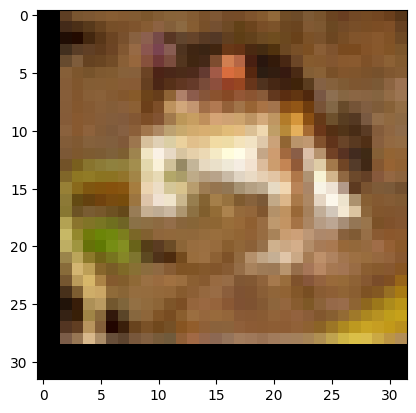

In [73]:
plt.imshow(torchvision.transforms.ToPILImage()(trainset[0][0]))

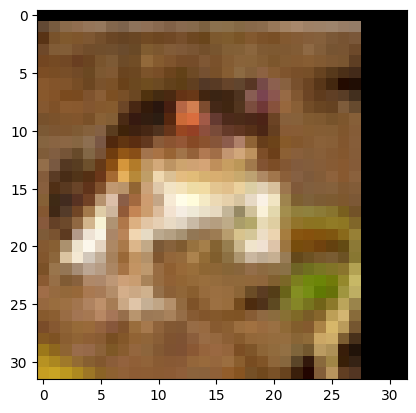

In [74]:
plt.imshow(  trainset[0][0].permute(1,2,0)  )

In [75]:
#net = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")
#net.heads.head = torch.nn.Linear(net.heads.head.in_features, 10)

net = model
print(net)
net.heads[0] = torch.nn.Linear(net.heads[0].in_features, 10)

net = net.train().to(device=DEVICE, dtype=DTYPE)

optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

loss_func = torch.nn.CrossEntropyLoss()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
  (encoder): Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_atten

In [76]:
def tran(epoch):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    scheduler.step()
    print('[%d] loss: %.3f' % (epoch + 1, running_loss))

In [77]:
def test():
    net.eval()
    all_counter=0
    correct_counter=0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        out = net(inputs)
        out = out.detach().cpu().argmax(1)
        t = labels.cpu()
        for m in range(len(t)):
            all_counter += 1
            if t[m] == out[m]:
                correct_counter += 1

    print(correct_counter, all_counter, correct_counter / all_counter)
    return (correct_counter / all_counter)

In [78]:
correctRate = 0
for i in range(epochs):
    tran(i)
    r = test()
    if(r > correctRate):
        correctRate = r
        print("best: ", r , " in NO: ", i)
        torch.save(net.cpu(),"checkpoint/vit.pth")
        net = net.to(DEVICE)

[1] loss: 1423.992
3006 10000 0.3006
best:  0.3006  in NO:  0
[2] loss: 1180.378
3919 10000 0.3919
best:  0.3919  in NO:  1
[3] loss: 1102.811
4300 10000 0.43
best:  0.43  in NO:  2
[4] loss: 1051.154
4638 10000 0.4638
best:  0.4638  in NO:  3
[5] loss: 1015.340
4666 10000 0.4666
best:  0.4666  in NO:  4
[6] loss: 989.000
4936 10000 0.4936
best:  0.4936  in NO:  5
[7] loss: 965.087
5085 10000 0.5085
best:  0.5085  in NO:  6
[8] loss: 952.096
5032 10000 0.5032
[9] loss: 931.464
5203 10000 0.5203
best:  0.5203  in NO:  8
[10] loss: 920.734
5312 10000 0.5312
best:  0.5312  in NO:  9
[11] loss: 908.146
5334 10000 0.5334
best:  0.5334  in NO:  10
[12] loss: 900.586
5306 10000 0.5306
[13] loss: 885.477
5416 10000 0.5416
best:  0.5416  in NO:  12
[14] loss: 878.281
5446 10000 0.5446
best:  0.5446  in NO:  13
[15] loss: 866.882
5543 10000 0.5543
best:  0.5543  in NO:  14
[16] loss: 857.515
5503 10000 0.5503
[17] loss: 847.622
5520 10000 0.552
[18] loss: 843.237
5641 10000 0.5641
best:  0.5641 

In [79]:
'''

[1] loss: 1039.766
5726 10000 0.5726
best:  0.5726  in NO:  0
[2] loss: 494.575
8055 10000 0.8055
best:  0.8055  in NO:  1
[3] loss: 246.069
8669 10000 0.8669
best:  0.8669  in NO:  2
[4] loss: 170.940
9136 10000 0.9136
best:  0.9136  in NO:  3
[5] loss: 122.860
9395 10000 0.9395
best:  0.9395  in NO:  4
[6] loss: 101.786
9409 10000 0.9409
best:  0.9409  in NO:  5
[7] loss: 67.831
9451 10000 0.9451
best:  0.9451  in NO:  6
[8] loss: 55.644
9499 10000 0.9499
best:  0.9499  in NO:  7
[9] loss: 42.075
9469 10000 0.9469
[10] loss: 38.531
9587 10000 0.9587
best:  0.9587  in NO:  9
[11] loss: 25.020
9565 10000 0.9565
[12] loss: 20.583
9613 10000 0.9613
best:  0.9613  in NO:  11
[13] loss: 15.646
9642 10000 0.9642
best:  0.9642  in NO:  12
[14] loss: 13.876
9616 10000 0.9616
[15] loss: 10.449
9660 10000 0.966
best:  0.966  in NO:  14
[16] loss: 8.551
9692 10000 0.9692
best:  0.9692  in NO:  15
[17] loss: 4.337
9681 10000 0.9681
[18] loss: 4.242
9740 10000 0.974
best:  0.974  in NO:  17
[19] loss: 1.846
9707 10000 0.9707
[20] loss: 3.379
9695 10000 0.9695


'''

'\n\n[1] loss: 1039.766\n5726 10000 0.5726\nbest:  0.5726  in NO:  0\n[2] loss: 494.575\n8055 10000 0.8055\nbest:  0.8055  in NO:  1\n[3] loss: 246.069\n8669 10000 0.8669\nbest:  0.8669  in NO:  2\n[4] loss: 170.940\n9136 10000 0.9136\nbest:  0.9136  in NO:  3\n[5] loss: 122.860\n9395 10000 0.9395\nbest:  0.9395  in NO:  4\n[6] loss: 101.786\n9409 10000 0.9409\nbest:  0.9409  in NO:  5\n[7] loss: 67.831\n9451 10000 0.9451\nbest:  0.9451  in NO:  6\n[8] loss: 55.644\n9499 10000 0.9499\nbest:  0.9499  in NO:  7\n[9] loss: 42.075\n9469 10000 0.9469\n[10] loss: 38.531\n9587 10000 0.9587\nbest:  0.9587  in NO:  9\n[11] loss: 25.020\n9565 10000 0.9565\n[12] loss: 20.583\n9613 10000 0.9613\nbest:  0.9613  in NO:  11\n[13] loss: 15.646\n9642 10000 0.9642\nbest:  0.9642  in NO:  12\n[14] loss: 13.876\n9616 10000 0.9616\n[15] loss: 10.449\n9660 10000 0.966\nbest:  0.966  in NO:  14\n[16] loss: 8.551\n9692 10000 0.9692\nbest:  0.9692  in NO:  15\n[17] loss: 4.337\n9681 10000 0.9681\n[18] loss: 4.